## Diffusion unet

In [1]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>7: fc.defaults.cpus=7

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

Jeremy notes that when a value of 0.33 is used below this gives better results.  See the discussion in lesson 24 about the errors found in the Karras notebook, in particular with respect to the FID

In [5]:
sig_data = 0.66

In [6]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

def scalings(sig):
    """ values as per the Karras paper
    """
    totvar = sig**2+sig_data**2
    # c_skip,c_out,c_in
    return sig_data**2/totvar,sig*sig_data/totvar.sqrt(),1/totvar.sqrt()

def noisify(x0):
    device = x0.device
    # This is to obtain the log normal distribution for sigma as per the paper
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    c_skip,c_out,c_in = scalings(sig)
    noised_input = x0 + noise*sig
    target = (x0-c_skip*noised_input)/c_out
    return (noised_input*c_in,sig.squeeze()),target

def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=0)

In [7]:
tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

### Train 

The code below is all based upon the diffuser code base

In [8]:
def unet_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

In [9]:
class UnetResBlock(nn.Module):
    def __init__(self, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None: nf = ni
        self.convs = nn.Sequential(unet_conv(ni, nf, ks, act=act, norm=norm),
                                   unet_conv(nf, nf, ks, act=act, norm=norm))
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)

    def forward(self, x): return self.convs(x) + self.idconv(x)

The class below shows an example of a python mixin.  When a class has inherited from two other classes that have the same name then when that method is called in the class that inherits from two other classes then it will be called in the first module and will recognise the method in the second class as the “super” method.  Hence the method in the first class is called, which then calls the method in the second class

In [11]:
class A:
    def __call__(self):
        super().__call__()
        print('a')

class B:
    def __call__(self): print('b')

class C(A,B): pass

In [12]:
C()()

b
a


In [13]:
class SaveModule:
    def forward(self, x, *args, **kwargs):
        self.saved = super().forward(x, *args, **kwargs)
        return self.saved

class SavedResBlock(SaveModule, UnetResBlock): pass
class SavedConv(SaveModule, nn.Conv2d): pass

The above approach means that we can again use a sequential for the down block since the saving is happening automatically

In [14]:
def down_block(ni, nf, add_down=True, num_layers=1):
    res = nn.Sequential(*[SavedResBlock(ni=ni if i==0 else nf, nf=nf)
                         for i in range(num_layers)])
    if add_down: res.append(SavedConv(nf, nf, 3, stride=2, padding=1))
    return res

In [15]:
def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))

In [16]:
class UpBlock(nn.Module):
    def __init__(self, ni, prev_nf, nf, add_up=True, num_layers=2):
        super().__init__()
        self.resnets = nn.ModuleList(
            [UnetResBlock((prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1))
        return self.up(x)

In [17]:
class UNet2DModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        nf = nfs[0]
        self.downs = nn.Sequential()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(down_block(ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = UnetResBlock(nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = unet_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d)

    def forward(self, inp):
        x = self.conv_in(inp[0])
        saved = [x]
        x = self.downs(x)
        saved += [p.saved for o in self.downs for p in o]
        x = self.mid_block(x)
        for block in self.ups: x = block(x, saved)
        return self.conv_out(x)

In [18]:
model = UNet2DModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)

In [19]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.496,0,train
0.337,0,eval
0.246,1,train
0.240,1,eval
0.209,2,train
0.222,2,eval
0.193,3,train
0.210,3,eval
0.185,4,train
0.232,4,eval


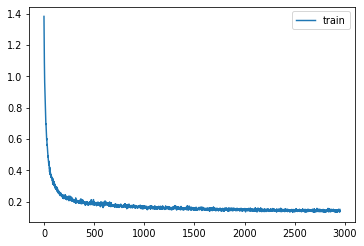

In [20]:
learn.fit(epochs)

## Timesteps 

To work as in the diffusers library the model needs to have time embeddings.  These are as used in transformers

In [22]:
emb_dim = 16
tsteps = torch.linspace(-10,10,100)
max_period= 10000

In [23]:
math.log(10000)

9.210340371976184

In [24]:
exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)

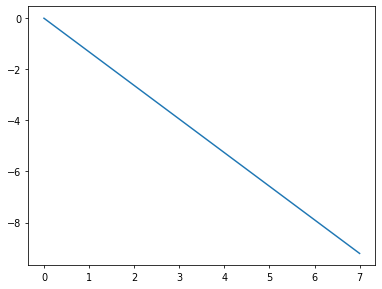

In [25]:
plt.plot(exponent);

In [26]:
emb = tsteps[:,None].float() * exponent.exp()[None,:]
emb.shape

torch.Size([100, 8])

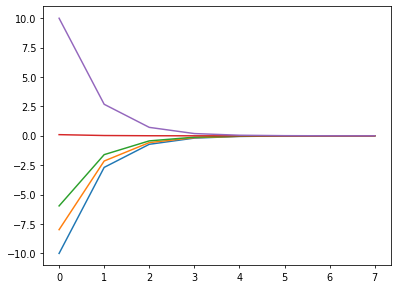

In [27]:
plt.plot(emb[0])
plt.plot(emb[10])
plt.plot(emb[20])
plt.plot(emb[50])
plt.plot(emb[-1]);

In [28]:
emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
emb.shape

torch.Size([100, 16])

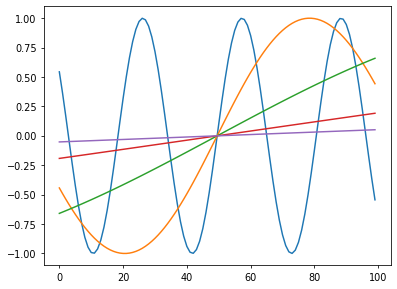

In [29]:
plt.plot(emb[:,0])
plt.plot(emb[:,1])
plt.plot(emb[:,2])
plt.plot(emb[:,3])
plt.plot(emb[:,4]);

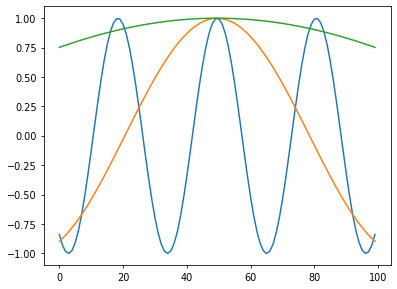

In [30]:
plt.plot(emb[:,8])
plt.plot(emb[:,9])
plt.plot(emb[:,10]);

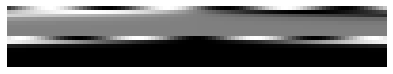

In [31]:
show_image(emb.T, figsize=(7,7));

In [32]:
def timestep_embedding(tsteps, emb_dim, max_period= 10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

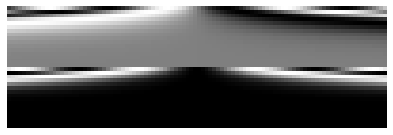

In [33]:
show_image(timestep_embedding(tsteps, 32, max_period=1000).T, figsize=(7,7));

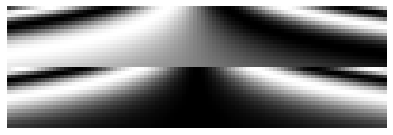

In [34]:
show_image(timestep_embedding(tsteps, 32, max_period=10).T, figsize=(7,7));

## Timestep model

In [35]:
from functools import wraps

In [36]:
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if act : layers.append(act())
    if norm: layers.append(norm(nf))
    return layers

In [37]:
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    """ This linear layer has the sequence changed so that the normalization and activation are before the actual
    linear layer.
    """
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Linear(ni, nf, bias=bias))
    return layers

In [38]:
class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None: nf = ni
        self.emb_proj = nn.Linear(n_emb, nf*2)
        self.conv1 = unet_conv(ni, nf, ks, act=act, norm=norm) #, bias=not norm)
        self.conv2 = unet_conv(nf, nf, ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)

    def forward(self, x, t):
        inp = x
        x = self.conv1(x)
        emb = self.emb_proj(F.silu(t))[:, :, None, None]
        scale,shift = torch.chunk(emb, 2, dim=1)
        x = x*(1+scale) + shift
        x = self.conv2(x)
        return x + self.idconv(inp)

The approach below is an alternative to the class mixin method above to facilitate the model activations.  In this case the wraps library simply ensures that any documentation of the wrapped method is avaibable to the parent

In [40]:
def saved(m, blk):
    m_ = m.forward

    @wraps(m.forward)
    def _f(*args, **kwargs):
        res = m_(*args, **kwargs)
        blk.saved.append(res)
        return res

    m.forward = _f
    return m

In [41]:
class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1):
        super().__init__()
        self.resnets = nn.ModuleList([saved(EmbResBlock(n_emb, ni if i==0 else nf, nf), self)
                                      for i in range(num_layers)])
        self.down = saved(nn.Conv2d(nf, nf, 3, stride=2, padding=1), self) if add_down else nn.Identity()

    def forward(self, x, t):
        self.saved = []
        for resnet in self.resnets: x = resnet(x, t)
        x = self.down(x)
        return x

In [42]:
class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2):
        super().__init__()
        self.resnets = nn.ModuleList(
            [EmbResBlock(n_emb, (prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, t, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1), t)
        return self.up(x)

In [43]:
class EmbUNetModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = unet_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

In [44]:
model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)

In [45]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.355,0,train
0.264,0,eval
0.211,1,train
0.239,1,eval
0.189,2,train
0.210,2,eval
0.179,3,train
0.203,3,eval
0.171,4,train
0.338,4,eval


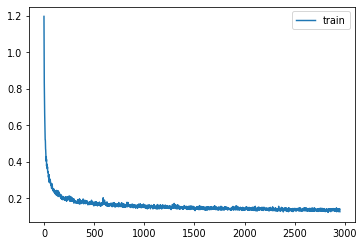

In [46]:
learn.fit(epochs)

## Sampling 

In [47]:
from miniai.fid import ImageEval

In [61]:
cmodel = torch.load('/home/models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

bs = 2048
tds2 = dsd.with_transform(transformi)
dls2 = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls2.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

In [62]:
sz = (512,1,32,32)

In [63]:
sz = (2048,1,32,32)

In [64]:
def sigmas_karras(n, sigma_min=0.01, sigma_max=80., rho=7.):
    ramp = torch.linspace(0, 1, n)
    min_inv_rho = sigma_min**(1/rho)
    max_inv_rho = sigma_max**(1/rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho-max_inv_rho))**rho
    return torch.cat([sigmas, tensor([0.])]).cuda()

def denoise(model, x, sig):
    sig = sig[None] #* torch.ones((len(x),1), device=x.device)
    c_skip,c_out,c_in = scalings(sig)
    return model((x*c_in, sig))*c_out + x*c_skip

In [65]:
def get_ancestral_step(sigma_from, sigma_to, eta=1.):
    if not eta: return sigma_to, 0.
    var_to,var_from = sigma_to**2,sigma_from**2
    sigma_up = min(sigma_to, eta * (var_to * (var_from-var_to)/var_from)**0.5)
    return (var_to-sigma_up**2)**0.5, sigma_up

@torch.no_grad()
def sample_euler_ancestral(x, sigs, i, model, eta=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    sigma_down,sigma_up = get_ancestral_step(sig, sig2, eta=eta)
    x = x + (x-denoised)/sig*(sigma_down-sig)
    return x + torch.randn_like(x)*sigma_up

In [66]:
@torch.no_grad()
def sample_euler(x, sigs, i, model):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    return x + (x-denoised)/sig*(sig2-sig)

@torch.no_grad()
def sample_heun(x, sigs, i, model, s_churn=0., s_tmin=0., s_tmax=float('inf'), s_noise=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    n = len(sigs)
    gamma = min(s_churn/(n-1), 2**0.5-1) if s_tmin<=sig<=s_tmax else 0.
    eps = torch.randn_like(x) * s_noise
    sigma_hat = sig * (gamma+1)
    if gamma > 0: x = x + eps * (sigma_hat**2-sig**2)**0.5
    denoised = denoise(model, x, sig)
    d = (x-denoised)/sig
    dt = sig2-sigma_hat
    x_2 = x + d*dt
    if sig2==0: return x_2
    denoised_2 = denoise(model, x_2, sig2)
    d_2 = (x_2-denoised_2)/sig2
    d_prime = (d+d_2)/2
    return x + d_prime*dt


In [67]:
def sample(sampler, model, steps=100, sigma_max=80., **kwargs):
    preds = []
    x = torch.randn(sz).cuda()*sigma_max
    sigs = sigmas_karras(steps, sigma_max=sigma_max)
    for i in progress_bar(range(len(sigs)-1)):
        x = sampler(x, sigs, i, model, **kwargs)
        preds.append(x)
    return preds

In [68]:
from scipy import integrate

In [69]:
def linear_multistep_coeff(order, t, i, j):
    if order-1 > i: raise ValueError(f'Order {order} too high for step {i}')
    def fn(tau):
        prod = 1.
        for k in range(order):
            if j == k: continue
            prod *= (tau-t[i-k]) / (t[i-j]-t[i-k])
        return prod
    return integrate.quad(fn, t[i], t[i+1], epsrel=1e-4)[0]

@torch.no_grad()
def sample_lms(model, steps=100, order=4, sigma_max=80.):
    preds = []
    x = torch.randn(sz).cuda()*sigma_max
    sigs = sigmas_karras(steps, sigma_max=sigma_max)
    ds = []
    for i in progress_bar(range(len(sigs)-1)):
        sig = sigs[i]
        denoised = denoise(model, x, sig)
        d = (x-denoised)/sig
        ds.append(d)
        if len(ds) > order: ds.pop(0)
        cur_order = min(i+1, order)
        coeffs = [linear_multistep_coeff(cur_order, sigs, i, j) for j in range(cur_order)]
        x = x + sum(coeff*d for coeff, d in zip(coeffs, reversed(ds)))
        preds.append(x)
    return preds

In [70]:
preds = sample_lms(model, steps=20, order=3)
# preds = sample(sample_euler_ancestral, model, steps=100, eta=1.)
# preds = sample(sample_euler, model, steps=100)
# preds = sample(sample_heun, model, steps=20, s_churn=0.5)

In [71]:
s = preds[-1]
s.min(),s.max()

(tensor(-1.08032, device='cuda:0'), tensor(1.37845, device='cuda:0'))

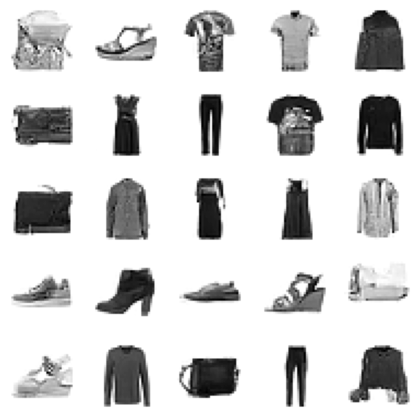

In [72]:
show_images(s[:25].clamp(-1,1), imsize=1.5)

In [73]:
# lms 20
ie.fid(s),ie.kid(s),s.shape

(0.9232177734375, 0.009685005061328411, torch.Size([2048, 1, 32, 32]))

In [74]:
preds = sample_lms(model, steps=20, order=3)
s = preds[-1]
ie.fid(s),ie.kid(s),s.shape

(1.2525634765625, 0.007465990725904703, torch.Size([2048, 1, 32, 32]))

In [75]:
preds = sample_lms(model, steps=20, order=3)
s = preds[-1]
ie.fid(s),ie.kid(s),s.shape

(1.0601959228515625, 0.00790930911898613, torch.Size([2048, 1, 32, 32]))